In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os

os.environ["TORCH_HOME"] = "/media/hdd/Datasets/"
import sys

sys.path.append("/media/hdd/github/sprintdl/")

In [2]:
from sprintdl.main import *
import sprintdl

In [3]:
device = torch.device("cuda", 0)
from torch.nn import init
import torch
import math

In [4]:
from sprintdl.models.efficientnet import *

# Define required

In [5]:
fpath = Path("/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/")

# train_transform = [A.Resize(128,128)]

# tfms = [ATransform(train_transform, c_in = 3)]
tfms = [make_rgb, to_byte_tensor, to_float_tensor, ResizeFixed(128)]
bs = 100

# Actual process

In [6]:
il = ImageList.from_files(fpath, tfms=tfms)

In [7]:
il

ImageList (18000 items)
[PosixPath('/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Trout/Trout/00338.png'), PosixPath('/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Trout/Trout/00179.png'), PosixPath('/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Trout/Trout/00094.png'), PosixPath('/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Trout/Trout/00599.png'), PosixPath('/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Trout/Trout/00293.png'), PosixPath('/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Trout/Trout/00100.png'), PosixPath('/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Trout/Trout/00457.png'), PosixPath('/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Trout/Trout/00059.png'), PosixPath('/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Trout/Trout/00366.png'), PosixPath('/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Trout/Trout/00592.png')...]
Path: /media/hdd/Datasets/Fish_Dataset/Fish_Dataset

In [8]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid=0.2))
ll = label_by_func(sd, lambda x: str(x).split("/")[-3], proc_y=CategoryProcessor())

In [9]:
n_classes = len(set(ll.train.y.items))
n_classes

9

In [10]:
data = ll.to_databunch(bs, c_in=3, c_out=n_classes)

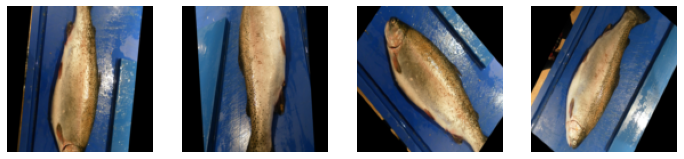

In [11]:
show_batch(data, 4)

# Training

In [12]:
lr = 1e-3
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr = combine_scheds(phases, cos_1cycle_anneal(lr / 10.0, lr, lr / 1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

cbfs = [
    partial(AvgStatsCallback, accuracy),
    partial(ParamScheduler, "lr", sched_lr),
    partial(ParamScheduler, "mom", sched_mom),
    partial(BatchTransformXCallback, norm_imagenette),
    ProgressCallback,
    Recorder,
    OverSampling,
    partial(CudaCallback, device),
]

loss_func = LabelSmoothingCrossEntropy()
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [13]:
arch = efficientnet(num_classes=n_classes, pretrained=True)

Loaded pretrained weights for efficientnet-b3


# OTher loss

In [14]:
loss_func = nll

In [16]:
clear_memory()
learn = Learner(arch, data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,-216.349020,0.571369,-249.756810,0.524291,01:17
1,-347.133112,0.583489,-435.039280,0.638585,01:17


In [17]:
learn.fit(4)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,-404.929150,0.621788,-468.858397,0.614434,01:16
1,-505.965129,0.603989,-677.229992,0.635777,01:17
2,-740.860101,0.635709,-918.910418,0.643639,01:17
3,-900.717847,0.666043,-983.539596,0.698680,01:17


# Label smooth CE

In [37]:
clear_memory()
learn = Learner(arch, data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.018521,0.799613,0.893805,0.830542,01:16
1,0.589770,0.961732,0.537130,0.977860,01:17


In [38]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.552182,0.977827,0.775419,0.879932,01:16
1,0.559090,0.975064,0.516422,0.987794,01:17
